In [1]:
#Libraries
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as data
from pandas_datareader import *
import math
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


#Model Result Analysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [2]:
#Scraping Dataset from Yahoo Finance using yfinance
#Getting data for the Apple Stock
aapl = yf.Ticker("AAPL")

# Apple Company Information
# aapl.info

# Apple's Historical Stock Prices (10 Year Period)
aapl.dataset = aapl.history(period="10y")

aapl.dataset.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-21,168.910004,171.529999,165.910004,166.419998,87227800,0.0,0.0
2022-04-22,166.460007,167.869995,161.500000,161.789993,84882400,0.0,0.0
2022-04-25,161.119995,163.169998,158.460007,162.880005,96046400,0.0,0.0
2022-04-26,162.250000,162.339996,156.720001,156.800003,95623200,0.0,0.0
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200,0.0,0.0
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800,0.0,0.0
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100,0.0,0.0
2022-05-02,156.710007,158.229996,153.270004,157.960007,123055300,0.0,0.0
2022-05-03,158.149994,160.710007,156.320007,159.479996,88912900,0.0,0.0


In [3]:
#Dataframe basic information on rows and columns
aapl.dataset.shape

(2517, 7)

In [4]:
#Dropped Columns 'Dividends' and 'Stock Splits'
aapl.dataset.drop(['Dividends', 'Stock Splits'], axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2012-05-04,17.647814,17.686957,17.283591,17.286037,529992400
2012-05-07,17.171360,17.516010,17.163102,17.415398,460118400
2012-05-08,17.418456,17.477172,17.086650,17.375643,497252000
2012-05-09,17.238634,17.553009,17.151477,17.406218,480704000
2012-05-10,17.571351,17.611107,17.383584,17.447191,333200000
...,...,...,...,...,...
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100
2022-05-02,156.710007,158.229996,153.270004,157.960007,123055300


In [5]:
#YFinance Bug- Dropped columns appears after being dropped so copying into new dataset
dataset = aapl.dataset [['Open', 'Close', 'High', 'Low','Volume']].copy()
dataset.tail()

,Open,Close,High,Low,Volume
Date,,,,,
2022-04-28,159.250000,163.639999,164.520004,158.929993,130216800
2022-04-29,161.839996,157.649994,166.199997,157.250000,131587100
2022-05-02,156.710007,157.960007,158.229996,153.270004,123055300
2022-05-03,158.149994,159.479996,160.710007,156.320007,88912900
2022-05-04,159.669998,163.050003,163.720001,159.259995,70901535


ADDING TECHNICAL INDICATORS TO DATASET

Stochastic Oscillator Indicator

In [6]:
# Calculating %K and %D
dataset['14-high'] = dataset['High'].rolling(14).max()
dataset['14-low'] = dataset['Low'].rolling(14).min()
dataset['%K'] = (dataset['Close'] - dataset['14-low'])*100/(dataset['14-high'] - dataset['14-low'])
dataset['%D'] = dataset['%K'].rolling(3).mean()


In [7]:
#Dropping 14-HIGH AND 14-LOW COLUMNS
dataset.drop(['14-high', '14-low'], axis = 1, inplace=True)

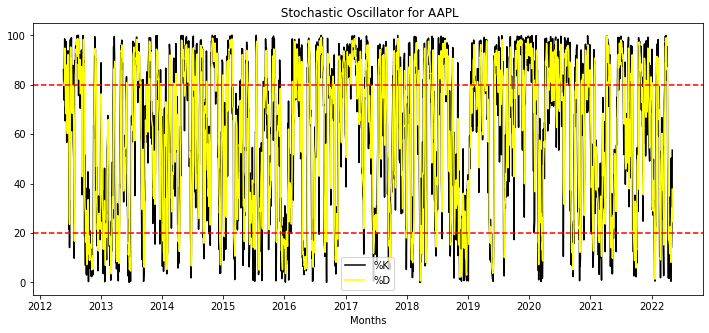

In [8]:
#Plotting SO Graph
plt.figure(figsize=(12, 5))
plt.title(' Stochastic Oscillator for AAPL')
plt.xlabel('Months')
plt.plot(dataset['%K'], label='%K', c='black')
plt.plot(dataset['%D'], label='%D',  c='yellow')
plt.axhline(20, linestyle='--', color="r")
plt.axhline(80, linestyle="--", color="r")
plt.legend()
plt.show()


In [9]:
# Adding Buy/Sell Signals from Sotchastic Oscillator Indicator
def categorise_so(row):  
    if row['%K'] <= 20 and row['%D'] <= 20:
        return 'Buy'
    elif row['%K'] >= 80 and  row['%D']>= 80:
        return 'Sell'
    else:
        return 'Hold'

    
   
dataset['SO Indicator'] = dataset.apply(lambda row: categorise_so(row), axis=1)


In [10]:
# Distrubition of the Indicator
print(dataset['SO Indicator'].value_counts())

Hold    1553
Sell     725
Buy      239
Name: SO Indicator, dtype: int64


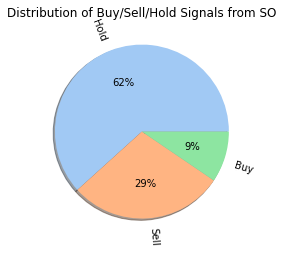

In [11]:
#Distrubition of the SO Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['SO Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from SO")
plt.show()

Relative Strength Index

In [12]:
delta = dataset['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
dataset['RSI'] = 100 - (100/(1 + rs))

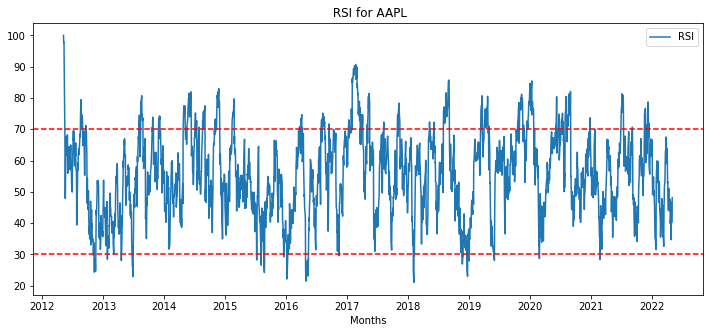

In [13]:
#Plotting RSI Graph
plt.figure(figsize=(12, 5))
plt.title(' RSI for AAPL')
plt.xlabel('Months')
plt.plot(dataset['RSI'], label='RSI')
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()



In [14]:
# Adding Buy/Sell Signals from RSI Indicator
def categorise_rsi(row):  
    if row['RSI'] <= 30:
        return 'Buy'
    elif row['RSI'] >= 70:
        return 'Sell'
    else:
        return 'Hold'
  
dataset['RSI Indicator'] = dataset.apply(lambda row: categorise_rsi(row), axis=1)

In [15]:
# Distrubition of the Indicator
print(dataset['RSI Indicator'].value_counts())

Hold    2086
Sell     369
Buy       62
Name: RSI Indicator, dtype: int64


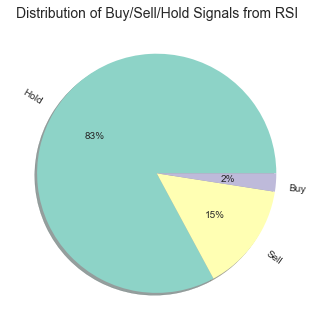

In [16]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['RSI Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set3")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from RSI", fontdict={'fontsize': 14})
plt.show()

Bollinger Bands

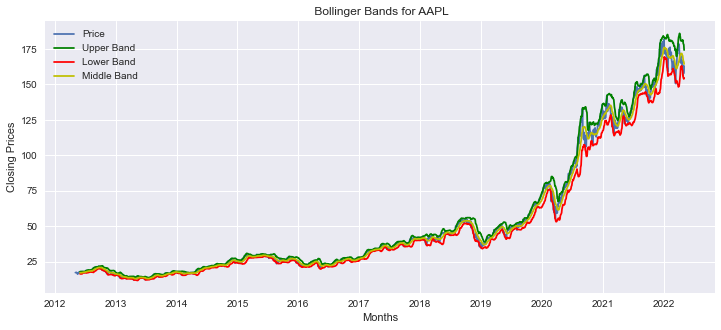

In [17]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    # SMA for 20 Days (Middle Band)
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()

    # Calculating Upper Band
    bollinger_upper = sma + (std * 2 )

    # Calculate Lower Band
    bollinger_lower = sma - (std * 2 )

    #Middle Band
    bollinger_middle = sma
    return bollinger_upper, bollinger_lower, bollinger_middle


closing_prices = dataset['Close']
bollinger_upper, bollinger_lower, bollinger_middle = get_bollinger_bands(closing_prices)

#Plotting the  Bollinger Bands
plt.figure(figsize=(12, 5))
plt.title(' Bollinger Bands for AAPL')
plt.xlabel('Months')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Price')
plt.plot(bollinger_upper, label='Upper Band', c='g')
plt.plot(bollinger_lower, label='Lower Band', c='r')
plt.plot(bollinger_middle, label='Middle Band', c='y')

plt.legend()
plt.show()

In [18]:
#Adding Bollinger Bands to the Dataset
dataset['Bollinger_Upper'] = bollinger_upper
dataset['Bollinger_Lower'] = bollinger_lower


In [19]:
# Adding Buy/Sell Signals from Bollinger Bands Indicator
def categorise_bollinger(row):  
    if row['Close'] < row['Bollinger_Lower']:
        return 'Buy'
    elif row['Close'] > row['Bollinger_Upper']:
        return 'Sell'
    else:
        return 'Hold'
    
   
dataset['Bollinger Indicator'] = dataset.apply(lambda row: categorise_bollinger(row), axis=1)


In [20]:
# Distrubition of the Indicator
print(dataset['Bollinger Indicator'].value_counts())

Hold    2219
Sell     188
Buy      110
Name: Bollinger Indicator, dtype: int64


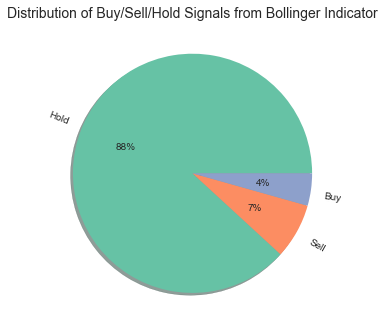

In [21]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['Bollinger Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set2")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from Bollinger Indicator", fontdict={'fontsize': 14})
plt.show()

Moving Average Convergence Divergence

In [22]:
# Calculating the MACD Line and the Signal Line
ema12 = dataset['Close'].ewm(span=12, adjust=False).mean()
ema26 = dataset['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()


#Appeding the MACD and Signal Data to Dataset
dataset['MACD'] = macd
dataset['Signal'] = signal


In [23]:
# Adding Buy/Sell Signals from MACD
signal = []

for i in range(len(dataset)):
   if dataset['MACD'][i] > dataset['Signal'][i] and dataset['MACD'][i-1] < dataset['Signal'][i-1]:
      signal.append('Buy')
   elif dataset['MACD'][i] < dataset['Signal'][i] and dataset['MACD'][i-1] > dataset['Signal'][i-1]:
      signal.append('Sell')
   else:
      signal.append('Hold')

  
    
dataset['MACD Indicator'] = signal

In [24]:
# Distrubition of the Indicator
print(dataset['MACD Indicator'].value_counts())

Hold    2342
Sell      88
Buy       87
Name: MACD Indicator, dtype: int64


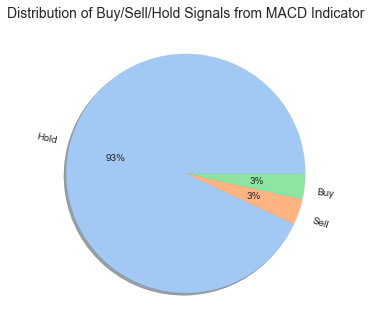

In [25]:
#Distrubition of the MACD Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['MACD Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel", 10)
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from MACD Indicator", fontdict={'fontsize': 14})
plt.show()

Addding Target Variable

In [26]:
# Recommender Based on the three indicators
def recommender(row): 
    # If All Share the Same Signal OutPut That Signal (Buy)
    if row['RSI Indicator'] == "Buy" and row['SO Indicator'] == 'Buy' and  row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
     # If Any 2 Indicators Share the Same Signal Output That Signal (buy)
    elif row['RSI Indicator'] == 'Buy' and row['SO Indicator'] == 'Buy':
        return 'Buy'
    elif row['RSI Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
    elif row['SO Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'   
    # If All Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell' and  row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell':
        return 'Sell'
    elif row['RSI Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    elif row['SO Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'    
    # If All Share the Same Signal OutPut That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold' and  row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold':
        return 'Hold'
    elif row['RSI Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    elif row['SO Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'      
    else:
        return 'Unclassed'

dataset['Recommender'] = dataset.apply(lambda row: recommender(row), axis=1)

In [27]:
# Distrubition of the Recommender
print(dataset['Recommender'].value_counts())


Hold    2016
Sell     390
Buy      111
Name: Recommender, dtype: int64


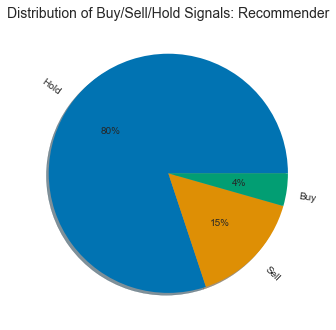

In [28]:
#Distrubition of the Recommender
labels = ["Hold", "Sell", "Buy"]
values = dataset['Recommender'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("colorblind" )
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals: Recommender", fontdict={'fontsize': 14})
plt.show()

Data Cleaning and Preprocessing

In [29]:
dataset.drop(['RSI Indicator', 'SO Indicator', 'MACD Indicator' , 'Bollinger Indicator'], axis = 1, inplace=True)

In [30]:
#Dataset shape after adding all the technical indicators 
dataset.shape

(2517, 13)

In [31]:
#Columns After Adding All The Technical Indicators
dataset.columns

Index(['Open', 'Close', 'High', 'Low', 'Volume', '%K', '%D', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Recommender'],
      dtype='object')

In [32]:
#Information regarding the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-05-04 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2517 non-null   float64
 1   Close            2517 non-null   float64
 2   High             2517 non-null   float64
 3   Low              2517 non-null   float64
 4   Volume           2517 non-null   int64  
 5   %K               2504 non-null   float64
 6   %D               2502 non-null   float64
 7   RSI              2516 non-null   float64
 8   Bollinger_Upper  2498 non-null   float64
 9   Bollinger_Lower  2498 non-null   float64
 10  MACD             2517 non-null   float64
 11  Signal           2517 non-null   float64
 12  Recommender      2517 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 275.3+ KB


In [33]:
#Checking for Null Values
dataset.isna().sum()

Open                0
Close               0
High                0
Low                 0
Volume              0
%K                 13
%D                 15
RSI                 1
Bollinger_Upper    19
Bollinger_Lower    19
MACD                0
Signal              0
Recommender         0
dtype: int64

In [34]:
#Dropping Null Values
dataset = dataset.dropna()
dataset.isna().sum()

Open               0
Close              0
High               0
Low                0
Volume             0
%K                 0
%D                 0
RSI                0
Bollinger_Upper    0
Bollinger_Lower    0
MACD               0
Signal             0
Recommender        0
dtype: int64

In [35]:
#let's check if there is any duplicate data
print(dataset.duplicated().any())
print(dataset.duplicated().sum())

False
0


In [36]:
#Dataframe after dopping null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2498 entries, 2012-06-01 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2498 non-null   float64
 1   Close            2498 non-null   float64
 2   High             2498 non-null   float64
 3   Low              2498 non-null   float64
 4   Volume           2498 non-null   int64  
 5   %K               2498 non-null   float64
 6   %D               2498 non-null   float64
 7   RSI              2498 non-null   float64
 8   Bollinger_Upper  2498 non-null   float64
 9   Bollinger_Lower  2498 non-null   float64
 10  MACD             2498 non-null   float64
 11  Signal           2498 non-null   float64
 12  Recommender      2498 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 273.2+ KB


In [37]:
# #Encode Categorical Variables
signal_dict = {'Hold': 0, 'Sell': 1, 'Buy': 2}

dataset['Recommender'] = dataset['Recommender'].map(signal_dict)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2498 entries, 2012-06-01 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2498 non-null   float64
 1   Close            2498 non-null   float64
 2   High             2498 non-null   float64
 3   Low              2498 non-null   float64
 4   Volume           2498 non-null   int64  
 5   %K               2498 non-null   float64
 6   %D               2498 non-null   float64
 7   RSI              2498 non-null   float64
 8   Bollinger_Upper  2498 non-null   float64
 9   Bollinger_Lower  2498 non-null   float64
 10  MACD             2498 non-null   float64
 11  Signal           2498 non-null   float64
 12  Recommender      2498 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 273.2 KB


In [38]:
# #Splitting the dataset into training and test sets
# #Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

#Independant and Dependent Variable
y=dataset.iloc[:,12:13] #Dependent variable
X=dataset.iloc[:,0:12] #Independent variable

#Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)


#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# Shape of Training and Test sets
print("x_train dataset: ", X_train.shape)
print(" y_train dataset: ", y_train.shape)
print(" x_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

x_train dataset:  (1748, 12)
 y_train dataset:  (1748, 1)
 x_test dataset:  (750, 12)
y_test dataset:  (750, 1)


In [40]:
y_train['Recommender'].value_counts()


0    1394
1     277
2      77
Name: Recommender, dtype: int64

In [41]:
y_test['Recommender'].value_counts()

0    603
1    113
2     34
Name: Recommender, dtype: int64

Text(0.5, 0, 'Trade Signals')

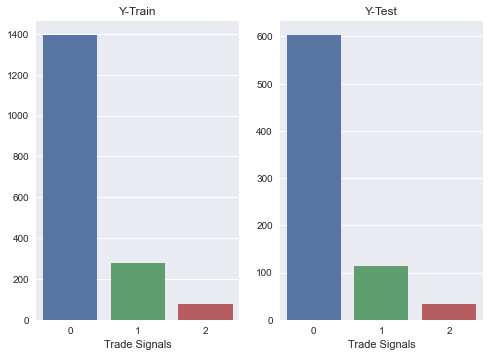

In [42]:
#Original Dataset  
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x=['0', '1','2'], y =[sum(y_train['Recommender'] == 0), sum(y_train['Recommender'] == 1), sum(y_train['Recommender'] == 2)], ax = ax1)
ax1.set_title("Y-Train")
ax1.set_xlabel('Trade Signals')

sns.barplot(x=['0', '1', '2'], y =[sum(y_test['Recommender'] == 0), sum(y_test['Recommender'] == 1), sum(y_test['Recommender'] == 2)], ax = ax2)
ax2.set_title("Y-Test")
ax2.set_xlabel('Trade Signals')

Text(0.5, 0, 'Trade Signals')

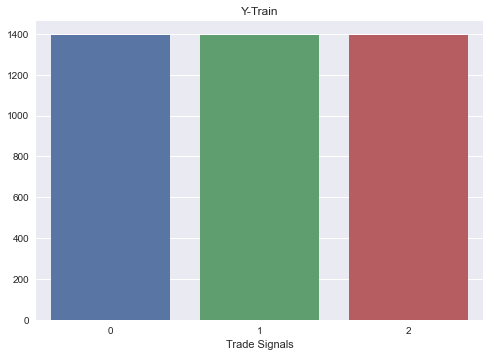

In [43]:
#Handling Imbalance data using SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)


fig = sns.barplot(x=['0', '1', '2'],  y =[sum(ysmote['Recommender'] == 0), sum(ysmote['Recommender'] == 1), sum(ysmote['Recommender'] == 2)])
fig.set_title("Y-Train")
fig.set_xlabel('Trade Signals')

HalvingGridSearchCV

In [81]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'max_depth': [None, 20, 40, 60, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 8, 10, 12],
    'n_estimators': [600, 700, 800, 1000, 1200, 1300]
}
# Create a based model
hgs_rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = gs_rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)


halving_cv = HalvingGridSearchCV(estimator = hgs_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, min_resources="exhaust", factor=3)
halving_cv.fit(Xsmote, ysmote)




C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 18
max_resources_: 4182
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1500
n_resources: 18
Fitting 3 folds for each of 1500 candidates, totalling 4500 fits
----------
iter: 1
n_candidates: 500
n_resources: 54
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
----------
iter: 2
n_candidates: 167
n_resources: 162
Fitting 3 folds for each of 167 candidates, totalling 501 fits
----------
iter: 3
n_candidates: 56
n_resources: 486
Fitting 3 folds for each of 56 candidates, totalling 168 fits
----------
iter: 4
n_candidates: 19
n_resources: 1458
Fitting 3 folds for each of 19 candidates, totalling 57 fits


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


HalvingGridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                    param_grid={'max_depth': [None, 20, 40, 60, 100],
                                'max_features': [2, 3],
                                'min_samples_leaf': [1, 2, 3, 4, 5],
                                'min_samples_split': [2, 4, 8, 10, 12],
                                'n_estimators': [600, 700, 800, 1000, 1200,
                                                 1300]},
                    verbose=2)

In [82]:
# Return set of parameters with the best performance
halving_cv.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 600}

In [83]:
# #Using best parameters to make predictions
halving_rf = RandomForestClassifier(max_depth= None, max_features= 3, min_samples_leaf= 1, min_samples_split= 4, n_estimators= 600)
halving_rf.fit(Xsmote, ysmote.values.ravel())

# max_depth= None, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 4, n_estimators= 600
# n_estimators= 800, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None

#Accuracy
y_pred = halving_rf.predict(X_test)

accuracy = accuracy_score(y_pred , y_test)
print("Accuracy Score :", accuracy) 
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("F1 Score: ", test_f1)

Accuracy Score : 0.9426666666666667
Precision Score : 0.8573305467247537
Recall Score :  0.8988125196217996
F1 Score:  0.8763259443855976
